In [7]:
import pandas as pd
import glob
import sys
sys.path.insert(1, '..')
from src import readfiles
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

# **Warning:**
# Files named 001 and 002 do not always correspond to the same crystal!
# So this information must be extracted from the metadata.
# So get all the data into one big list!

def read_scans_and_split_by_xtl(allfolders):

    data_list = []
    metadata_list = []

    for i in range(len(allfolders)):
        _, data, metadata = readfiles.import_jeol_wdscans(allfolders[i],
                                                             'data001_mm.csv', 'data001.cnd',
                                                             comment_line_num=80,
                                                             return_metadata=True)
        data_list.append(data)
        metadata_list.append(metadata)
    
        _, data, metadata = readfiles.import_jeol_wdscans(allfolders[i],
                                                             'data002_mm.csv', 'data002.cnd',
                                                             comment_line_num=80,
                                                             return_metadata=True)
        data_list.append(data)
        metadata_list.append(metadata)
    
    # And then split based on crystal, and save to 'cleaned_data' folder.
    
    xtls = list(set([m.crystal for m in metadata_list])) # Find the unique crystals
    data_by_xtl = {xtls[0]: [], xtls[1]: []}
    
    for i, m in enumerate(metadata_list):
    
        data_by_xtl[m.crystal].append(data_list[i])

    return data_by_xtl

def average_spectra(data):

    """ data = a list of pandas dataframes """

    # Rehape data into np arrays
    cpsdata = np.empty(shape=(len(data[0].cps), len(data)))
    cps_per_nA_data = np.empty(shape=(len(data[0].cps), len(data)))
    Ldata = np.empty(shape=(len(data[0].L), len(data)))

    for i in range(len(data)):
        cpsdata[:, i] = data[i].cps
        cps_per_nA_data[:,i] = data[i].cps_per_nA
        Ldata[:, i] = data[i].L

    # Check L-axes are the same:
    L_axis_check = np.array([Ldata[:,n] == Ldata[:,0]
                             for n in range(len(data))])


    if L_axis_check.all().all() == False:
        print(Ldata[1:10, :])
        raise Exception('L values are not the same between datasets!')

    # Average the data
    mean_df = pd.DataFrame({'L': Ldata[:,0],
                            'cps': cpsdata.mean(axis=1),
                            'cps_per_nA': cps_per_nA_data.mean(axis=1),
                            'cps_per_nA_stdev': cps_per_nA_data.std(axis=1)})

    return mean_df

# Compile the ANU data and save

In [8]:
budd_folders = sorted(glob.glob('../data/raw/peak_shapes/raw_data_ANU/Buddingtonite/*'))
budd_data = read_scans_and_split_by_xtl(budd_folders)
budd_avg = {'LDE1': average_spectra(budd_data['LDE1']),
             'LDE1H': average_spectra(budd_data['LDE1H'])}

In [9]:
glass_folders = sorted(glob.glob('../data/raw/peak_shapes/raw_data_ANU/GlassA870/*'))
glass_data = read_scans_and_split_by_xtl(glass_folders)
glass_avg = {'LDE1': average_spectra(glass_data['LDE1']),
             'LDE1H': average_spectra(glass_data['LDE1H'])}

In [10]:
nitride_folders = sorted(glob.glob('../data/raw/peak_shapes/raw_data_ANU/*'))
nitride_folders = [n for n in nitride_folders if 'Buddingtonite' not in n if 'Glass' not in n]
nitride_names = [Path(n).stem for n in nitride_folders]
nitride_data = read_scans_and_split_by_xtl(nitride_folders)

In [11]:
for xtl in ['LDE1', 'LDE1H']:

    # Check if folder exists, if not, create it
    output_folder = Path(f'../data/interim/peak_shapes/cleaned_data_ANU/{xtl}/')
    
    if not output_folder.exists():
        output_folder.mkdir(parents=True, exist_ok=True)
    
    for i in range(len(nitride_data[xtl])):
        nitride_data[xtl][i].to_csv(output_folder / Path(nitride_names[i] + '.csv'))
    
    budd_avg[xtl].to_csv(output_folder / Path('Buddingtonite.csv'))
    glass_avg[xtl].to_csv(output_folder / Path('GlassA870.csv'))


NameError: name 'mtransforms' is not defined

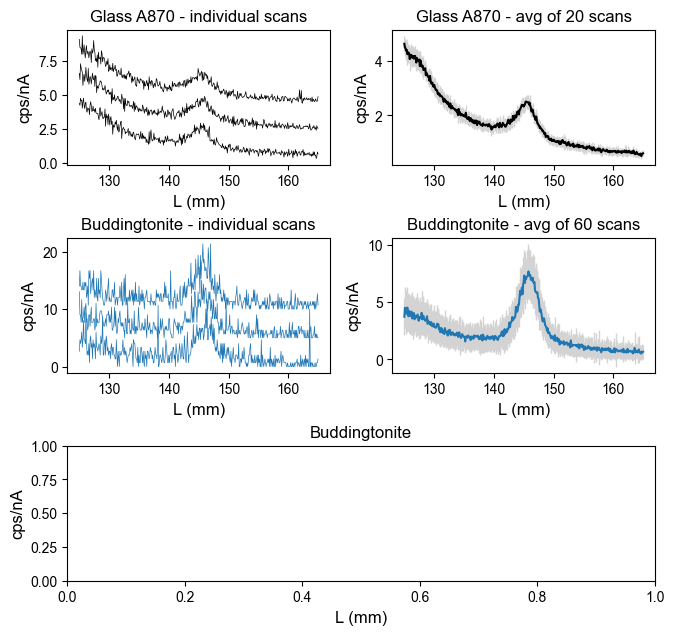

In [14]:
mosaic = """
    AB
    CD
    EE
    """

fig = plt.figure(constrained_layout=True, figsize=(17*0.39, 16*0.39))
ax_dict = fig.subplot_mosaic(mosaic)

for i in range(3):
    ax_dict["A"].plot(glass_data["LDE1H"][i].L
           , glass_data["LDE1H"][i].cps_per_nA + i*2
           , linestyle='-', color='k', lw=0.5)
    
for i in range(3):
    ax_dict["C"].plot(budd_data["LDE1H"][i].L
           , budd_data["LDE1H"][i].cps_per_nA + i*5
           , linestyle='-', color='tab:blue', lw=0.5)
    
ax_dict["B"].errorbar(x=glass_avg["LDE1H"].L
                    , y=glass_avg["LDE1H"].cps_per_nA
                    , yerr=glass_avg["LDE1H"].cps_per_nA_stdev
                    , elinewidth=1, ecolor="lightgrey", color="k"
                    )

ax_dict["D"].errorbar(x=budd_avg["LDE1H"].L
                    , y=budd_avg["LDE1H"].cps_per_nA
                    , yerr=budd_avg["LDE1H"].cps_per_nA_stdev
                    , elinewidth=1, ecolor="lightgrey", color="tab:blue"
                    )

# ADD THE LONGSCAN BACK IN HERE!! (AND UNCOMMENT SUBPLOT E STUFF BELOW)
# data['budd_longscan'].plot(x='L', y='cps_per_nA', ax=ax_dict["E"], color="tab:orange", lw=1)
# data['buddingtonite'].plot(x='L', y='cps_per_nA', ax=ax_dict["E"], color="tab:blue", lw=1)

# Annotate axes -------------------------------------------------
for k, ax in ax_dict.items():
    ax.set_ylabel('cps/nA')
    ax.set_xlabel('L (mm)')
    
# ax_dict["E"].plot([146,146], [0,9], ':k', lw=1)
# ax_dict["E"].legend([f'{budd_long.total_time_mins}-min scan at {budd_long.current} nA',
#                      f'Avg of 60 {budd_LDE1H_scans[0].total_time_mins}-min scans at {budd_LDE1H_scans[0].current} nA'])

ax_dict["A"].set_title("Glass A870 - individual scans")
ax_dict["B"].set_title("Glass A870 - avg of 20 scans")
ax_dict["C"].set_title("Buddingtonite - individual scans")
ax_dict["D"].set_title("Buddingtonite - avg of 60 scans")
ax_dict["E"].set_title("Buddingtonite")

for label, ax in ax_dict.items():
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize=12, verticalalignment='top', fontfamily='Arial',
            bbox=dict(facecolor='w', edgecolor='grey', pad=3.0))

fig.align_labels()
# plt.savefig("Budd_and_Glass_scans.pdf")
plt.show()


# Compile the StA data and save

In [26]:
allfolders = sorted(glob.glob('../data/raw/peak_shapes/raw_data_StA/*'))

names = [Path(n).stem for n in allfolders]
data = read_scans_and_split_by_xtl(allfolders)

for xtl in data.keys():

    # Check if folder exists, if not, create it
    output_folder = Path(f'../data/interim/peak_shapes/cleaned_data_StA/{xtl}/')
    
    if not output_folder.exists():
        output_folder.mkdir(parents=True, exist_ok=True)
    
    for i in range(len(data[xtl])):
        data[xtl][i].to_csv(output_folder / Path(names[i] + '.csv'))
